In [124]:
# Feature Extraction with Univariate Statistical Tests (Chi-squared for classification)
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, SelectFpr, f_classif
from DataPreprocessor import DataPreprocessor
from sklearn.preprocessing import MinMaxScaler
from FeatureSelection import FeatureSelection
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from pandas_ml import ConfusionMatrix
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import sys

import matplotlib.pyplot as plt
%matplotlib inline

In [125]:
def update_progress(job_title, progress):
    length = 20 # modify this to change the length
    block = int(round(length*progress))
    msg = "\r{0}: [{1}] {2}%".format(job_title, "#"*block + "-"*(length-block), round(progress*100, 2))
    if progress >= 1: msg += " DONE\r\n"
    sys.stdout.write(msg)
    sys.stdout.flush()

### READ IN TRAINING AND TEST DATA FROM FILE

In [126]:
test_df = pd.read_csv("census-income.test.csv", sep=",", names=['age', 'workclass', 'fnlwgt', 'education', 'educational-num', 'marital-status','occupation', 'relationship', 'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'])

In [127]:
df = pd.read_csv("census-income.data.csv", sep=",", names=['age', 'workclass', 'fnlwgt', 'education', 'educational-num', 'marital-status','occupation', 'relationship', 'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'])

In [128]:
df.shape

(32561, 15)

In [129]:
test_df.shape

(16281, 15)

#### Preprocess test data and training data by deleting missing values, removing leading and trailing white spaces as well as converting the categorical fields to numeric fields

In [130]:
dp = DataPreprocessor(test_df)
test_df = dp.runTestSetPreprocessor()

In [131]:
dpp = DataPreprocessor(df)
train_df = dpp.runProjectPreprocessor()

In [132]:
train_df.columns

Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'income', 'Female', 'Male', 'Adm-clerical',
       'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing',
       'Handlers-cleaners', 'Machine-op-inspct', 'Other-service',
       'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales',
       'Tech-support', 'Transport-moving', 'Husband', 'Not-in-family',
       'Other-relative', 'Own-child', 'Unmarried', 'Wife',
       'Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other', 'White',
       'Gov', 'Private', 'Self-emp', 'Without-pay', 'Cambodia', 'Canada',
       'China', 'Columbia', 'Cuba', 'Dominican-Republic', 'Ecuador',
       'El-Salvador', 'England', 'France', 'Germany', 'Greece', 'Guatemala',
       'Haiti', 'Honduras', 'Hong', 'Hungary', 'India', 'Iran', 'Ireland',
       'Italy', 'Jamaica', 'Japan', 'Laos', 'Mexico', 'Nicaragua',
       'Outlying-US(Guam-USVI-etc)', 'Peru', 'Philippines', 'Poland',
 

#### Remove prediction class from both the training data and test data, and convert both to numpy arrays in preparation for feature selection

In [133]:
Y = train_df['income'].values
train_df = train_df.drop('income', axis=1)
X = train_df.values

In [134]:
Y_test = test_df['income'].values
test_df = test_df.drop('income', axis=1)
X_test = test_df.values

### FEATURE SELECTION


In [135]:
def extractRFEFeatureColumns(data):
    outt = []
    for i,j in enumerate(data):
        if j == True:
            outt.append(i)
    return outt   

fs = FeatureSelection()
features_range = list(range(1,81))
chi2_features = {}
rfe_features = {}
rfe_forest_features = {}
rfe_dt_features= {}
rfe_svm_features = {}
rfe_nb_features = {}
rfe_knn_features ={}

#### Run Feature selection algorithms for range provided above in order to select the best features within said range

In [136]:
for i,feat in enumerate(features_range):
    if feat == 80:
        fit, features_list = fs.runUnivariateSelectionMethod(X,Y,'chi2', 'all')
    else:
        fit, features_list = fs.runUnivariateSelectionMethod(X,Y,'chi2', feat)

    fit2 = fs.runRFESelectionMethod(X,Y,feat)
    fit3 = fs.runRFESelectionMethodRF(X,Y,feat)
    fit4 = fs.runRFESelectionMethodDT(X,Y,feat)

    #fit6 = fs.runRFESelectionMethodNB(X,Y,feat)
    #fit7 = fs.runRFESelectionMethodKNN(X,Y,feat)
    
    chi2_features[feat] = features_list
    rfe_features[feat] = extractRFEFeatureColumns(fit2.support_)
    rfe_forest_features[feat] = extractRFEFeatureColumns(fit3.support_)
    rfe_dt_features[feat] = extractRFEFeatureColumns(fit4.support_)

    #rfe_nb_features[feat] = extractRFEFeatureColumns(fit6.support_)
    #rfe_knn_features[feat] = extractRFEFeatureColumns(fit7.support_)
    
    #fit5 = fs.runRFESelectionMethodSVM(X,Y,2)
    #rfe_svm_features[feat] = extractRFEFeatureColumns(fit5.support_)
    
    update_progress("Feature Selection Process", i/len(features_range))
update_progress("Feature Selection Process", 1)




Feature Selection Process: [####################] 100% DONE


In [137]:
def plotAccuracyForModelFeatures(models):
    plot_list = [v['to_plot'] for k,v in models.items()]
    plot_list
    x = list(zip(*plot_list))[0]
    y = list(zip(*plot_list))[1]
    plt.plot(x, y)
    
    
def getMaximumAccuracyFeatures(data):
    plot_list = [v['to_plot'] for k,v in data.items()]
    
    return max(plot_list, key=lambda item:item[1])

# DATA MODELLING SECTION

## LOGISTIC REGRESSION


In [138]:
def runLogisticRegressionModel(train_x, train_y, test_x, test_y):
    model = LogisticRegression()
    model.fit(train_x, train_y)
    predicted = model.predict(test_x)
    report = "-- CLASSIFICATION REPORT -- \n", metrics.classification_report(test_y, predicted), "-- CONFUSION MATRIX --  \n", confusion_matrix(Y_test, predicted), "\n", "-- ACCURACY SCORE -- \n ", metrics.accuracy_score(Y_test, predicted), "\n"
    accuracy_score = metrics.accuracy_score(Y_test, predicted)
    cm = ConfusionMatrix(Y_test, predicted)
    return cm, report,accuracy_score

def automateLogisticRegressionWithChi2():
    models = {}
    for k,v in chi2_features.items():
        #print("******Chi2 LOGISTIC REGRESSION with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runLogisticRegressionModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score, "to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
    return models

def automateLogisticRegressionWithRFE():
    models = {}
    for k,v in rfe_features.items():
        #print("******RFE LOGISTIC REGRESSION with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runLogisticRegressionModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score, "to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
    return models

def logisticRegressioinTrainSet(train_x, train_y):
    
    model = LogisticRegression()
    model.fit(train_x, train_y)
    predicted = model.predict(train_x)
    report = "-- CLASSIFICATION REPORT -- \n", metrics.classification_report(train_y, predicted), "-- CONFUSION MATRIX --  \n", confusion_matrix(train_y, predicted), "\n", "-- ACCURACY SCORE -- \n ", metrics.accuracy_score(train_y, predicted), "\n"
    accuracy_score = metrics.accuracy_score(train_y, predicted)
    cm = ConfusionMatrix(train_y, predicted)
    return cm, report,accuracy_score

def automateLogisticRegressionWithRFEForest():
    models = {}
    for k,v in rfe_forest_features.items():
        #print("******RFE LOGISTIC REGRESSION with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runLogisticRegressionModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score, "to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
    return models


#### LOGISTIC REGRESSION USING ALL FEATURES (80)

In [139]:
lr_cm, lr_report, lr_acc = runLogisticRegressionModel(X,Y,X_test,Y_test)
print("(Test SET)Accuracy when all features are used is: ", lr_acc*100, "%")
print(lr_cm.print_stats())

(Test SET)Accuracy when all features are used is:  82.1314741036 %
population: 15060
P: 3700
N: 11360
PositiveTest: 4573
NegativeTest: 10487
TP: 2791
TN: 9578
FP: 1782
FN: 909
TPR: 0.754324324324
TNR: 0.843133802817
PPV: 0.610321452001
NPV: 0.913321254887
FPR: 0.156866197183
FDR: 0.389678547999
FNR: 0.245675675676
ACC: 0.821314741036
F1_score: 0.674725009066
MCC: 0.559334060243
informedness: 0.597458127141
markedness: 0.523642706888
prevalence: 0.245683930943
LRP: 4.80871174205
LRN: 0.29138397115
DOR: 16.5030070908
FOR: 0.086678745113
None


In [140]:
lrt_cw, lrt_rep, lrt_acc = logisticRegressioinTrainSet(X,Y)
print("(Training SET) Accuracy when all features are used is: ", lrt_acc*100, "%")
print(lrt_cw.print_stats())

(Training SET) Accuracy when all features are used is:  79.8949051862 %
population: 17508
P: 7508
N: 10000
PositiveTest: 7252
NegativeTest: 10256
TP: 5620
TN: 8368
FP: 1632
FN: 1888
TPR: 0.748534896111
TNR: 0.8368
PPV: 0.774958632101
NPV: 0.815912636505
FPR: 0.1632
FDR: 0.225041367899
FNR: 0.251465103889
ACC: 0.798949051862
F1_score: 0.761517615176
MCC: 0.588096567432
informedness: 0.585334896111
markedness: 0.590871268607
prevalence: 0.428832533699
LRP: 4.58661088303
LRN: 0.30050801134
DOR: 15.2628572615
FOR: 0.184087363495
None


In [141]:
lr_rfe_models = automateLogisticRegressionWithRFE()
lr_chi2_models = automateLogisticRegressionWithChi2()
lr_rfe_forest = automateLogisticRegressionWithRFEForest()

/Users/ibrahimdawha/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


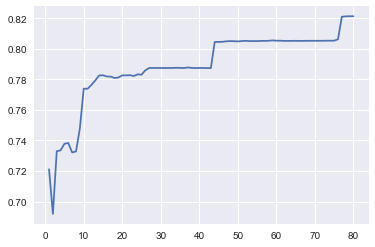

In [142]:
plotAccuracyForModelFeatures(lr_rfe_models)

In [143]:
print("The best accuracy for rfe is: ", getMaximumAccuracyFeatures(lr_rfe_models)[1], " with ", getMaximumAccuracyFeatures(lr_rfe_models)[0], " features")

The best accuracy for rfe is:  0.821314741036  with  79  features


In [144]:
best_feats = getMaximumAccuracyFeatures(lr_rfe_models)[0]
lr_rfe_models[best_feats]['cm'].print_stats()

population: 15060
P: 3700
N: 11360
PositiveTest: 4573
NegativeTest: 10487
TP: 2791
TN: 9578
FP: 1782
FN: 909
TPR: 0.754324324324
TNR: 0.843133802817
PPV: 0.610321452001
NPV: 0.913321254887
FPR: 0.156866197183
FDR: 0.389678547999
FNR: 0.245675675676
ACC: 0.821314741036
F1_score: 0.674725009066
MCC: 0.559334060243
informedness: 0.597458127141
markedness: 0.523642706888
prevalence: 0.245683930943
LRP: 4.80871174205
LRN: 0.29138397115
DOR: 16.5030070908
FOR: 0.086678745113


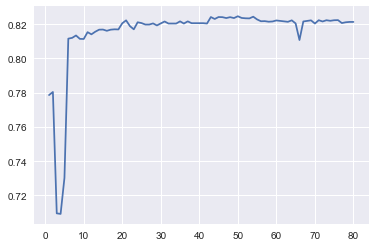

In [145]:
plotAccuracyForModelFeatures(lr_chi2_models)

In [146]:
print("The best accuracy for chi2 is: ", getMaximumAccuracyFeatures(lr_chi2_models)[1], " with ", getMaximumAccuracyFeatures(lr_chi2_models)[0], " features")
best_feats = getMaximumAccuracyFeatures(lr_chi2_models)[0]
lr_chi2_models[best_feats]['cm'].print_stats()

The best accuracy for chi2 is:  0.824634794157  with  50  features
population: 15060
P: 3700
N: 11360
PositiveTest: 4441
NegativeTest: 10619
TP: 2750
TN: 9669
FP: 1691
FN: 950
TPR: 0.743243243243
TNR: 0.851144366197
PPV: 0.619229903175
NPV: 0.910537715416
FPR: 0.148855633803
FDR: 0.380770096825
FNR: 0.256756756757
ACC: 0.824634794157
F1_score: 0.675592679032
MCC: 0.561148205355
informedness: 0.59438760944
markedness: 0.529767618591
prevalence: 0.245683930943
LRP: 4.99304745313
LRN: 0.301660642958
DOR: 16.551869028
FOR: 0.0894622845842


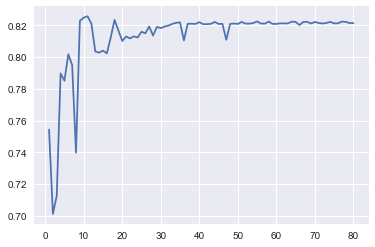

In [147]:
plotAccuracyForModelFeatures(lr_rfe_forest)

In [148]:
print("The best accuracy for RFE (FOREST) is: ", getMaximumAccuracyFeatures(lr_rfe_forest)[1], " with ", getMaximumAccuracyFeatures(lr_rfe_forest)[0], " features")
best_feats = getMaximumAccuracyFeatures(lr_rfe_forest)[0]
lr_rfe_forest[best_feats]['cm'].print_stats()

The best accuracy for RFE (FOREST) is:  0.825630810093  with  11  features
population: 15060
P: 3700
N: 11360
PositiveTest: 4050
NegativeTest: 11010
TP: 2562
TN: 9872
FP: 1488
FN: 1138
TPR: 0.692432432432
TNR: 0.869014084507
PPV: 0.632592592593
NPV: 0.89663941871
FPR: 0.130985915493
FDR: 0.367407407407
FNR: 0.307567567568
ACC: 0.825630810093
F1_score: 0.661161290323
MCC: 0.545101338651
informedness: 0.561446516939
markedness: 0.529232011303
prevalence: 0.245683930943
LRP: 5.28631211857
LRN: 0.353927022647
DOR: 14.9361641816
FOR: 0.10336058129


## KNN ALGORITHM

In [149]:
def runKNNAlgorithmModel(train_x, train_y, test_x, test_y, neighbors=10):
    knn = KNeighborsClassifier(n_neighbors=neighbors)
    knn.fit(train_x, train_y)
    predicted = knn.predict(test_x)
    report = "-- CLASSIFICATION REPORT -- \n", metrics.classification_report(test_y, predicted), "-- CONFUSION MATRIX --  \n", confusion_matrix(Y_test, predicted), "\n", "-- ACCURACY SCORE -- \n ", metrics.accuracy_score(Y_test, predicted), "\n"
    accuracy_score = metrics.accuracy_score(Y_test, predicted)
    cm = ConfusionMatrix(Y_test, predicted)
    return cm, report,accuracy_score


def automateKNNAlgorithmModelWithChi2():
    models = {}
    for k,v in chi2_features.items():
        #print("******Chi2 KNN model with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runKNNAlgorithmModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score, "to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
    return models

def automateKNNAlgorithmModelWithRFE():
    models = {}
    for k,v in rfe_features.items():
        #print("******RFE KNN Model with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runKNNAlgorithmModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score, "to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
    return models

def knnOnTrainSet(train_x, train_y, neighbors=10):
    model = KNeighborsClassifier(n_neighbors=neighbors)
    model.fit(train_x, train_y)
    predicted = model.predict(train_x)
    report = "-- CLASSIFICATION REPORT -- \n", metrics.classification_report(train_y, predicted), "-- CONFUSION MATRIX --  \n", confusion_matrix(train_y, predicted), "\n", "-- ACCURACY SCORE -- \n ", metrics.accuracy_score(train_y, predicted), "\n"
    accuracy_score = metrics.accuracy_score(train_y, predicted)
    cm = ConfusionMatrix(train_y, predicted)
    return cm, report,accuracy_score
def automateKNNAlgorithmModelWithRFEForest():
    models = {}
    for k,v in rfe_forest_features.items():
        #print("******RFE KNN Model with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runKNNAlgorithmModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score, "to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
    return models

#### KNN CROSS VALIDATION (Finding best value for K)

In [150]:
def knnFindBestValueK(train_x, train_y, k_len):
    mylist = list(range(1,k_len))
    neigh = filter(lambda x: x % 2 != 0, mylist) ## IT HELPS TO HAVE ODD NUMBER FOR K'S
    cv_scores = {}
    for k in neigh:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, train_x, train_y, cv=10, scoring='accuracy')
        cv_scores[k] = scores.mean() 
    
    best_k=list(cv_scores.items())
    plt.plot(*zip(*best_k))
    plt.show()
    return cv_scores
    

#### RUN KNN WITH ALL FEATURES (80)

In [151]:
knn_cm, knn_report, knn_acc = runKNNAlgorithmModel(X,Y,X_test,Y_test)
print("(TEST SET) Accuracy when all features are used is: ", knn_acc*100, "%")
knn_cm.print_stats()

(TEST SET) Accuracy when all features are used is:  83.8911022576 %
population: 15060
P: 3700
N: 11360
PositiveTest: 4470
NegativeTest: 10590
TP: 2872
TN: 9762
FP: 1598
FN: 828
TPR: 0.776216216216
TNR: 0.859330985915
PPV: 0.642505592841
NPV: 0.921813031161
FPR: 0.140669014085
FDR: 0.357494407159
FNR: 0.223783783784
ACC: 0.838911022576
F1_score: 0.70305997552
MCC: 0.598874880585
informedness: 0.635547202132
markedness: 0.564318624003
prevalence: 0.245683930943
LRP: 5.51803267598
LRN: 0.260416285985
DOR: 21.1892764506
FOR: 0.0781869688385


In [152]:
knn_cmt, knn_reportt, knn_acct = knnOnTrainSet(X,Y)
print("(TRAINING SET) Accuracy when all features are used is: ", knn_acct*100, "%")
knn_cmt.print_stats()

(TRAINING SET) Accuracy when all features are used is:  85.3609778387 %
population: 17508
P: 7508
N: 10000
PositiveTest: 7259
NegativeTest: 10249
TP: 6102
TN: 8843
FP: 1157
FN: 1406
TPR: 0.81273308471
TNR: 0.8843
PPV: 0.840611654498
NPV: 0.862815884477
FPR: 0.1157
FDR: 0.159388345502
FNR: 0.18726691529
ACC: 0.853609778387
F1_score: 0.826437326471
MCC: 0.70022301259
informedness: 0.69703308471
markedness: 0.703427538974
prevalence: 0.428832533699
LRP: 7.02448647113
LRN: 0.211768534762
DOR: 33.1705863622
FOR: 0.137184115523


In [153]:
knn_model = automateKNNAlgorithmModelWithChi2()


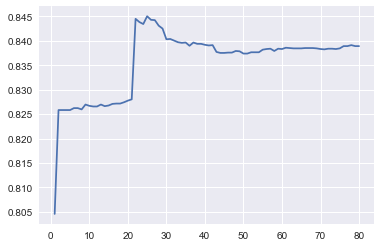

In [154]:
plotAccuracyForModelFeatures(knn_model)

In [155]:
print("The best accuracy for chi2 is: ", getMaximumAccuracyFeatures(knn_model)[1], " with ", getMaximumAccuracyFeatures(knn_model)[0], " features")

The best accuracy for chi2 is:  0.845019920319  with  25  features


In [156]:
best_feats = getMaximumAccuracyFeatures(knn_model)[0]
knn_model[best_feats]['cm'].print_stats()

population: 15060
P: 3700
N: 11360
PositiveTest: 3918
NegativeTest: 11142
TP: 2642
TN: 10084
FP: 1276
FN: 1058
TPR: 0.714054054054
TNR: 0.887676056338
PPV: 0.674323634507
NPV: 0.905043977742
FPR: 0.112323943662
FDR: 0.325676365493
FNR: 0.285945945946
ACC: 0.845019920319
F1_score: 0.693620372801
MCC: 0.59044300087
informedness: 0.601730110392
markedness: 0.579367612249
prevalence: 0.245683930943
LRP: 6.35709565365
LRN: 0.322128713402
DOR: 19.7346445354
FOR: 0.0949560222581


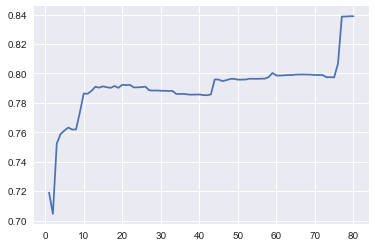

In [157]:
knn_model2 = automateKNNAlgorithmModelWithRFE()
plotAccuracyForModelFeatures(knn_model2)

In [158]:
print("The best accuracy for rfe is: ", getMaximumAccuracyFeatures(knn_model2)[1], " with ", getMaximumAccuracyFeatures(knn_model2)[0], " features")

The best accuracy for rfe is:  0.838911022576  with  79  features


In [159]:
best_feats = getMaximumAccuracyFeatures(knn_model2)[0]
knn_model2[best_feats]['cm'].print_stats()

population: 15060
P: 3700
N: 11360
PositiveTest: 4470
NegativeTest: 10590
TP: 2872
TN: 9762
FP: 1598
FN: 828
TPR: 0.776216216216
TNR: 0.859330985915
PPV: 0.642505592841
NPV: 0.921813031161
FPR: 0.140669014085
FDR: 0.357494407159
FNR: 0.223783783784
ACC: 0.838911022576
F1_score: 0.70305997552
MCC: 0.598874880585
informedness: 0.635547202132
markedness: 0.564318624003
prevalence: 0.245683930943
LRP: 5.51803267598
LRN: 0.260416285985
DOR: 21.1892764506
FOR: 0.0781869688385


In [160]:
knn_model3 = automateKNNAlgorithmModelWithRFEForest()

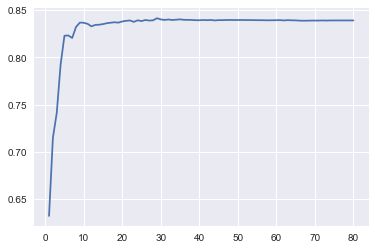

In [161]:
plotAccuracyForModelFeatures(knn_model3)


In [162]:
print("The best accuracy for rfe forest is: ", getMaximumAccuracyFeatures(knn_model3)[1], " with ", getMaximumAccuracyFeatures(knn_model3)[0], " features")

The best accuracy for rfe forest is:  0.841235059761  with  29  features


In [163]:
best_feats = getMaximumAccuracyFeatures(knn_model3)[0]
knn_model3[best_feats]['cm'].print_stats()

population: 15060
P: 3700
N: 11360
PositiveTest: 4399
NegativeTest: 10661
TP: 2854
TN: 9815
FP: 1545
FN: 846
TPR: 0.771351351351
TNR: 0.863996478873
PPV: 0.648783814503
NPV: 0.920645342838
FPR: 0.136003521127
FDR: 0.351216185497
FNR: 0.228648648649
ACC: 0.841235059761
F1_score: 0.7047783677
MCC: 0.60148614247
informedness: 0.635347830225
markedness: 0.569429157342
prevalence: 0.245683930943
LRP: 5.67155427272
LRN: 0.264640718151
DOR: 21.4311475284
FOR: 0.0793546571616


## RANDOM FOREST

In [164]:
def runRandomForestModel(train_x, train_y, test_x, test_y):
    rf_model = RandomForestClassifier(n_jobs=2)
    rf_model.fit(train_x, train_y)
    predicted = rf_model.predict(test_x)
    report = "-- CLASSIFICATION REPORT -- \n", metrics.classification_report(test_y, predicted), "-- CONFUSION MATRIX --  \n", confusion_matrix(Y_test, predicted), "\n", "-- ACCURACY SCORE -- \n ", metrics.accuracy_score(Y_test, predicted), "\n"
    accuracy_score = metrics.accuracy_score(Y_test, predicted)
    cm = ConfusionMatrix(Y_test, predicted)
    return cm, report,accuracy_score

def automateRandomForestModelWithChi2():
    models = {}
    for k,v in chi2_features.items():
        #print("******Chi2 Random Forest model with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runRandomForestModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score, "to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
    return models

def automateRandomForestModelWithRFE():
    models = {}
    for k,v in rfe_features.items():
        #print("******RFE Random Forest Model with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runRandomForestModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score, "to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
    return models

def randomForestOnTrainSet(train_x, train_y):
    model = RandomForestClassifier(n_jobs=2)
    model.fit(train_x, train_y)
    predicted = model.predict(train_x)
    report = "-- CLASSIFICATION REPORT -- \n", metrics.classification_report(train_y, predicted), "-- CONFUSION MATRIX --  \n", confusion_matrix(train_y, predicted), "\n", "-- ACCURACY SCORE -- \n ", metrics.accuracy_score(train_y, predicted), "\n"
    accuracy_score = metrics.accuracy_score(train_y, predicted)
    cm = ConfusionMatrix(train_y, predicted)
    return cm, report,accuracy_score


def automateRandomForestModelWithRFEForest():
    models = {}
    for k,v in rfe_forest_features.items():
        #print("******RFE Random Forest Model with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runRandomForestModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score, "to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
    return models


#### RANDOM FOREST USING ALL AVAILABLE FEATURES (80)

In [165]:
rf_cm, rf_report, rf_acc = runRandomForestModel(X,Y,X_test,Y_test)
print("(TEST SET) -- Accuracy when all features are used is: ", rf_acc*100, "%")
rf_cm.print_stats()

(TEST SET) -- Accuracy when all features are used is:  82.3240371846 %
population: 15060
P: 3700
N: 11360
PositiveTest: 4354
NegativeTest: 10706
TP: 2696
TN: 9702
FP: 1658
FN: 1004
TPR: 0.728648648649
TNR: 0.854049295775
PPV: 0.619200734956
NPV: 0.90622081076
FPR: 0.145950704225
FDR: 0.380799265044
FNR: 0.271351351351
ACC: 0.823240371846
F1_score: 0.669481003228
MCC: 0.553319125501
informedness: 0.582697944423
markedness: 0.525421545717
prevalence: 0.245683930943
LRP: 4.99242982428
LRN: 0.317723289152
DOR: 15.7131377986
FOR: 0.0937791892397


In [166]:
rft_cm, rft_report, rft_acc = randomForestOnTrainSet(X,Y)
print("(TRAINING SET) -- Accuracy when all features are used is: ", rft_acc*100, "%")
rft_cm.print_stats()

(TRAINING SET) -- Accuracy when all features are used is:  98.7834132968 %
population: 17508
P: 7508
N: 10000
PositiveTest: 7383
NegativeTest: 10125
TP: 7339
TN: 9956
FP: 44
FN: 169
TPR: 0.977490676612
TNR: 0.9956
PPV: 0.994040362996
NPV: 0.983308641975
FPR: 0.0044
FDR: 0.00595963700393
FNR: 0.0225093233884
ACC: 0.987834132968
F1_score: 0.985696058022
MCC: 0.975217516523
informedness: 0.973090676612
markedness: 0.977349004971
prevalence: 0.428832533699
LRP: 222.156971957
LRN: 0.0226088021177
DOR: 9826.1274879
FOR: 0.0166913580247


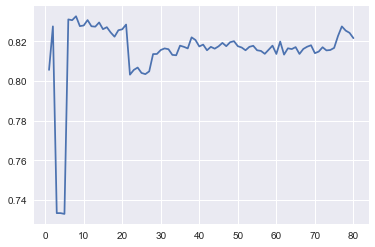

In [167]:
rf_chi2 = automateRandomForestModelWithChi2()
plotAccuracyForModelFeatures(rf_chi2)

In [168]:
print("The best accuracy for chi2 is: ", getMaximumAccuracyFeatures(rf_chi2)[1], " with ", getMaximumAccuracyFeatures(rf_chi2)[0], " features")

The best accuracy for chi2 is:  0.832602921647  with  8  features


In [169]:
best_feats = getMaximumAccuracyFeatures(rf_chi2)[0]
rf_chi2[best_feats]['cm'].print_stats()

population: 15060
P: 3700
N: 11360
PositiveTest: 4359
NegativeTest: 10701
TP: 2769
TN: 9770
FP: 1590
FN: 931
TPR: 0.748378378378
TNR: 0.860035211268
PPV: 0.63523743978
NPV: 0.91299878516
FPR: 0.139964788732
FDR: 0.36476256022
FNR: 0.251621621622
ACC: 0.832602921647
F1_score: 0.68718203251
MCC: 0.57754166048
informedness: 0.608413589646
markedness: 0.54823622494
prevalence: 0.245683930943
LRP: 5.34690464049
LRN: 0.292571302111
DOR: 18.2755608698
FOR: 0.0870012148397


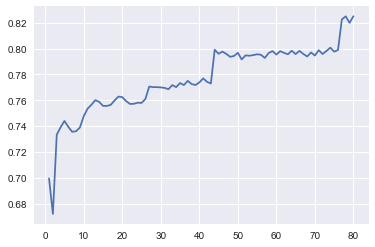

In [170]:
rf_rfe = automateRandomForestModelWithRFE()
plotAccuracyForModelFeatures(rf_rfe)

In [171]:
print("The best accuracy for rfe is: ", getMaximumAccuracyFeatures(rf_rfe)[1], " with ", getMaximumAccuracyFeatures(rf_rfe)[0], " features")

The best accuracy for rfe is:  0.824966799469  with  80  features


In [172]:
best_feats = getMaximumAccuracyFeatures(rf_rfe)[0]
rf_rfe[best_feats]['cm'].print_stats()

population: 15060
P: 3700
N: 11360
PositiveTest: 4332
NegativeTest: 10728
TP: 2698
TN: 9726
FP: 1634
FN: 1002
TPR: 0.729189189189
TNR: 0.856161971831
PPV: 0.622807017544
NPV: 0.906599552573
FPR: 0.143838028169
FDR: 0.377192982456
FNR: 0.270810810811
ACC: 0.824966799469
F1_score: 0.671812749004
MCC: 0.55667652229
informedness: 0.58535116102
markedness: 0.529406570117
prevalence: 0.245683930943
LRP: 5.06951602766
LRN: 0.316307918035
DOR: 16.0271549923
FOR: 0.0934004474273


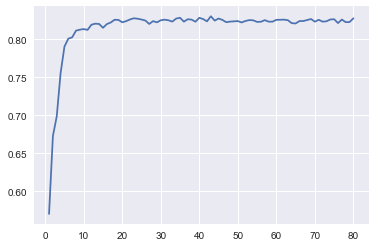

In [173]:
rf_rfe_forest = automateRandomForestModelWithRFEForest()
plotAccuracyForModelFeatures(rf_rfe_forest)

In [174]:
print("The best accuracy for rfe forest is: ", getMaximumAccuracyFeatures(rf_rfe_forest)[1], " with ", getMaximumAccuracyFeatures(rf_rfe_forest)[0], " features")

The best accuracy for rfe forest is:  0.8302124834  with  43  features


In [175]:
best_feats = getMaximumAccuracyFeatures(rf_rfe_forest)[0]
rf_rfe_forest[best_feats]['cm'].print_stats()

population: 15060
P: 3700
N: 11360
PositiveTest: 4263
NegativeTest: 10797
TP: 2703
TN: 9800
FP: 1560
FN: 997
TPR: 0.730540540541
TNR: 0.862676056338
PPV: 0.63406052076
NPV: 0.907659535056
FPR: 0.137323943662
FDR: 0.36593947924
FNR: 0.269459459459
ACC: 0.8302124834
F1_score: 0.678889865629
MCC: 0.566883875209
informedness: 0.593216596879
markedness: 0.541720055816
prevalence: 0.245683930943
LRP: 5.31983367983
LRN: 0.312353006067
DOR: 17.0314790525
FOR: 0.092340464944


## NAIVE BAYES

In [176]:
def runNaiveBayesModel(train_x, train_y, test_x, test_y):
    model = GaussianNB()
    model.fit(train_x, train_y)
    predicted = model.predict(test_x)
    report = "-- CLASSIFICATION REPORT -- \n", metrics.classification_report(test_y, predicted), "-- CONFUSION MATRIX --  \n", confusion_matrix(Y_test, predicted), "\n", "-- ACCURACY SCORE -- \n ", metrics.accuracy_score(Y_test, predicted), "\n"
    accuracy_score = metrics.accuracy_score(Y_test, predicted)
    cm = ConfusionMatrix(Y_test, predicted)
    return cm, report,accuracy_score

def automateNaiveBayesModelWithChi2():
    models = {}
    for k,v in chi2_features.items():
        #print("******Chi2 Naive Bayes model with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runNaiveBayesModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score, "to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
    return models

def automateNaiveBayesModelWithRFE():
    models = {}
    for k,v in rfe_features.items():
        #print("******RFE Naive Bayes with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runNaiveBayesModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score, "to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
    return models

def automateNaiveBayesModelWithRFEForest():
    models = {}
    for k,v in rfe_forest_features.items():
        #print("******RFE Naive Bayes with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runNaiveBayesModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score,"to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
    return models


def trainSetNaiveBayes(train_x, train_y):
    model = GaussianNB()    
    model.fit(train_x, train_y)
    predicted = model.predict(train_x)
    report = "-- CLASSIFICATION REPORT -- \n", metrics.classification_report(train_y, predicted), "-- CONFUSION MATRIX --  \n", confusion_matrix(train_y, predicted), "\n", "-- ACCURACY SCORE -- \n ", metrics.accuracy_score(train_y, predicted), "\n"
    accuracy_score = metrics.accuracy_score(train_y, predicted)
    cm = ConfusionMatrix(train_y, predicted)
    return cm, report,accuracy_score

#### RUN NAIVE BAYES ON DATA WITH ALL FEATURES(80)

In [177]:
nb_cm, nb_report, nb_acc = runNaiveBayesModel(X,Y,X_test,Y_test)
print("(Test SET) Accuracy when all features are used is: ", nb_acc*100, "%")
nb_cm.print_stats()

(Test SET) Accuracy when all features are used is:  78.0677290837 %
population: 15060
P: 3700
N: 11360
PositiveTest: 5579
NegativeTest: 9481
TP: 2988
TN: 8769
FP: 2591
FN: 712
TPR: 0.807567567568
TNR: 0.771919014085
PPV: 0.53557985302
NPV: 0.924902436452
FPR: 0.228080985915
FDR: 0.46442014698
FNR: 0.192432432432
ACC: 0.780677290837
F1_score: 0.644034917556
MCC: 0.516568783259
informedness: 0.579486581652
markedness: 0.460482289472
prevalence: 0.245683930943
LRP: 3.54070535221
LRN: 0.249290960478
DOR: 14.2031036561
FOR: 0.0750975635481


In [178]:
nbt_cm, nbt_report, nbt_acc = trainSetNaiveBayes(X,Y)
print("(TRAINING SET) Accuracy when all features are used is: ", nbt_acc*100, "%")
nbt_cm.print_stats()

(TRAINING SET) Accuracy when all features are used is:  78.5583733151 %
population: 17508
P: 7508
N: 10000
PositiveTest: 8344
NegativeTest: 9164
TP: 6049
TN: 7705
FP: 2295
FN: 1459
TPR: 0.805673947789
TNR: 0.7705
PPV: 0.724952061361
NPV: 0.840790048014
FPR: 0.2295
FDR: 0.275047938639
FNR: 0.194326052211
ACC: 0.785583733151
F1_score: 0.76318445622
MCC: 0.57093420338
informedness: 0.576173947789
markedness: 0.565742109375
prevalence: 0.428832533699
LRP: 3.510561864
LRN: 0.252207725128
DOR: 13.9193272618
FOR: 0.159209951986


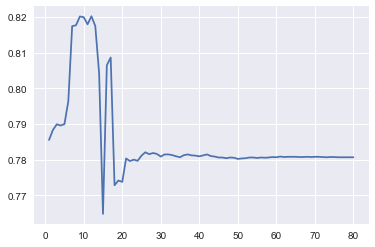

In [179]:
nb1 = automateNaiveBayesModelWithChi2()
plotAccuracyForModelFeatures(nb1)

In [180]:
print("The best accuracy for chi2 is: ", getMaximumAccuracyFeatures(nb1)[1], " with ", getMaximumAccuracyFeatures(nb1)[0], " features")

The best accuracy for chi2 is:  0.820185922975  with  12  features


In [181]:
best_feats = getMaximumAccuracyFeatures(nb1)[0]
nb1[best_feats]['cm'].print_stats()

population: 15060
P: 3700
N: 11360
PositiveTest: 3666
NegativeTest: 11394
TP: 2329
TN: 10023
FP: 1337
FN: 1371
TPR: 0.629459459459
TNR: 0.882306338028
PPV: 0.635297326787
NPV: 0.879673512375
FPR: 0.117693661972
FDR: 0.364702673213
FNR: 0.370540540541
ACC: 0.820185922975
F1_score: 0.632364919902
MCC: 0.513365817119
informedness: 0.511765797488
markedness: 0.514970839162
prevalence: 0.245683930943
LRP: 5.34828680588
LRN: 0.419968127361
DOR: 12.7349826271
FOR: 0.120326487625


/Users/ibrahimdawha/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


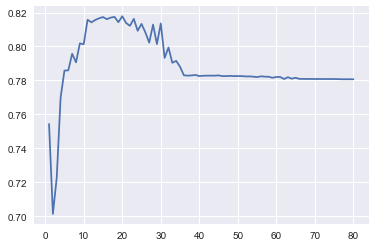

In [182]:
nb2 = automateNaiveBayesModelWithRFEForest()
plotAccuracyForModelFeatures(nb2)

In [183]:
print("The best accuracy for rfe (Random Forest) is: ", getMaximumAccuracyFeatures(nb2)[1], " with ", getMaximumAccuracyFeatures(nb2)[0], " features")

The best accuracy for rfe (Random Forest) is:  0.817795484728  with  20  features


In [184]:
best_feats = getMaximumAccuracyFeatures(nb2)[0]
nb2[best_feats]['cm'].print_stats()

population: 15060
P: 3700
N: 11360
PositiveTest: 3312
NegativeTest: 11748
TP: 2134
TN: 10182
FP: 1178
FN: 1566
TPR: 0.576756756757
TNR: 0.896302816901
PPV: 0.644323671498
NPV: 0.866700715015
FPR: 0.103697183099
FDR: 0.355676328502
FNR: 0.423243243243
ACC: 0.817795484728
F1_score: 0.608670849971
MCC: 0.491675684179
informedness: 0.473059573658
markedness: 0.511024386513
prevalence: 0.245683930943
LRP: 5.56193273069
LRN: 0.472210100495
DOR: 11.7785128375
FOR: 0.133299284985


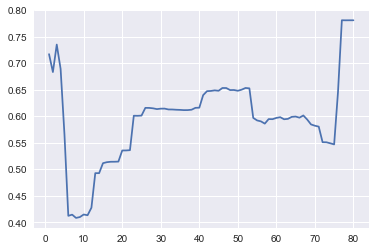

In [185]:
nb3 = automateNaiveBayesModelWithRFE()
plotAccuracyForModelFeatures(nb3)

In [186]:
print("The best accuracy for rfe (Logistic regression) is: ", getMaximumAccuracyFeatures(nb3)[1], " with ", getMaximumAccuracyFeatures(nb3)[0], " features")

The best accuracy for rfe (Logistic regression) is:  0.780743691899  with  77  features


In [187]:
best_feats = getMaximumAccuracyFeatures(nb3)[0]
nb3[best_feats]['cm'].print_stats()

population: 15060
P: 3700
N: 11360
PositiveTest: 5582
NegativeTest: 9478
TP: 2990
TN: 8768
FP: 2592
FN: 710
TPR: 0.808108108108
TNR: 0.771830985915
PPV: 0.53565030455
NPV: 0.925089681367
FPR: 0.228169014085
FDR: 0.46434969545
FNR: 0.191891891892
ACC: 0.780743691899
F1_score: 0.644257703081
MCC: 0.51691501237
informedness: 0.579939094024
markedness: 0.460739985918
prevalence: 0.245683930943
LRP: 3.54170837504
LRN: 0.248619057013
DOR: 14.2455225178
FOR: 0.0749103186326


## DECISION TREES

In [188]:
def runDecisionTreeModel(train_x, train_y, test_x, test_y):
    model = DecisionTreeClassifier()
    model.fit(train_x, train_y)
    predicted = model.predict(test_x)
    report = "-- CLASSIFICATION REPORT -- \n", metrics.classification_report(test_y, predicted), "-- CONFUSION MATRIX --  \n", confusion_matrix(Y_test, predicted), "\n", "-- ACCURACY SCORE -- \n ", metrics.accuracy_score(Y_test, predicted), "\n"
    accuracy_score = metrics.accuracy_score(Y_test, predicted)
    cm = ConfusionMatrix(Y_test, predicted)
    return cm, report,accuracy_score

def automateDecisionTreeModelWithChi2():
    models = {}
    for k,v in chi2_features.items():
        #print("******Chi2 Support Vector Machine model with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runDecisionTreeModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score,"to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
    return models

def automateDecisionTreeModelWithRFE():
    models = {}
    for k,v in rfe_features.items():
        #print("******RFE Support Vector Machine with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runDecisionTreeModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score,"to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
    return models


def trainSetDecisionTree(train_x, train_y):
    model = DecisionTreeClassifier()
    model.fit(train_x, train_y)
    predicted = model.predict(train_x)
    report = "-- CLASSIFICATION REPORT -- \n", metrics.classification_report(train_y, predicted), "-- CONFUSION MATRIX --  \n", confusion_matrix(train_y, predicted), "\n", "-- ACCURACY SCORE -- \n ", metrics.accuracy_score(train_y, predicted), "\n"
    accuracy_score = metrics.accuracy_score(train_y, predicted)
    cm = ConfusionMatrix(train_y, predicted)
    return cm, report,accuracy_score

def automateDecisionTreeModelWithRFEForest():
    models = {}
    for k,v in rfe_forest_features.items():
        #print("******RFE Support Vector Machine with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runDecisionTreeModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score, "to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
    return models

In [189]:
dt_cm, dt_report, dt_acc = runDecisionTreeModel(X,Y,X_test,Y_test)
print("(TEST SET) Accuracy when all features are used is: ", dt_acc*100, "%")
dt_cm.print_stats()

(TEST SET) Accuracy when all features are used is:  78.4462151394 %
population: 15060
P: 3700
N: 11360
PositiveTest: 4968
NegativeTest: 10092
TP: 2711
TN: 9103
FP: 2257
FN: 989
TPR: 0.732702702703
TNR: 0.801320422535
PPV: 0.545692431562
NPV: 0.902001585414
FPR: 0.198679577465
FDR: 0.454307568438
FNR: 0.267297297297
ACC: 0.784462151394
F1_score: 0.6255191509
MCC: 0.488957010478
informedness: 0.534023125238
markedness: 0.447694016976
prevalence: 0.245683930943
LRP: 3.68786118861
LRN: 0.333571053202
DOR: 11.0556990878
FOR: 0.0979984145858


In [190]:
dtt_cm, dtt_report, dtt_acc = trainSetDecisionTree(X,Y)
print("(TRAINING SET) Accuracy when all features are used is: ", dtt_acc*100, "%")
dtt_cm.print_stats()

(TRAINING SET) Accuracy when all features are used is:  99.9942883253 %
population: 17508
P: 7508
N: 10000
PositiveTest: 7507
NegativeTest: 10001
TP: 7507
TN: 10000
FP: 0
FN: 1
TPR: 0.999866808737
TNR: 1.0
PPV: 1.0
NPV: 0.999900009999
FPR: 0.0
FDR: 0.0
FNR: 0.000133191262653
ACC: 0.999942883253
F1_score: 0.999933399933
MCC: 0.99988340923
informedness: 0.999866808737
markedness: 0.999900009999
prevalence: 0.428832533699
LRP: inf
LRN: 0.000133191262653
DOR: inf
FOR: 9.99900009999e-05


/Users/ibrahimdawha/anaconda/lib/python3.6/site-packages/pandas_ml/confusion_matrix/bcm.py:332: RuntimeWarning: divide by zero encountered in double_scalars
  return(np.float64(self.TPR) / self.FPR)


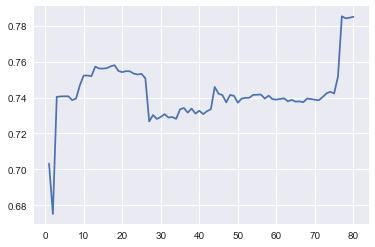

In [191]:
mm = automateDecisionTreeModelWithRFE()
plotAccuracyForModelFeatures(mm)

In [192]:
print("The best accuracy for rfe (Logistic regression) is: ", getMaximumAccuracyFeatures(mm)[1], " with ", getMaximumAccuracyFeatures(mm)[0], " features")

The best accuracy for rfe (Logistic regression) is:  0.785258964143  with  77  features


In [193]:
best_feats = getMaximumAccuracyFeatures(mm)[0]
mm[best_feats]['cm'].print_stats()

population: 15060
P: 3700
N: 11360
PositiveTest: 4970
NegativeTest: 10090
TP: 2718
TN: 9108
FP: 2252
FN: 982
TPR: 0.734594594595
TNR: 0.80176056338
PPV: 0.546881287726
NPV: 0.902675916749
FPR: 0.19823943662
FDR: 0.453118712274
FNR: 0.265405405405
ACC: 0.785258964143
F1_score: 0.626989619377
MCC: 0.491042081115
informedness: 0.536355157975
markedness: 0.449557204476
prevalence: 0.245683930943
LRP: 3.70559262637
LRN: 0.331028261463
DOR: 11.1941881034
FOR: 0.0973240832507


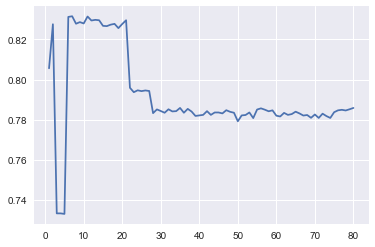

In [194]:
mm2 = automateDecisionTreeModelWithChi2()
plotAccuracyForModelFeatures(mm2)

In [195]:
print("The best accuracy for chi2 is: ", getMaximumAccuracyFeatures(mm2)[1], " with ", getMaximumAccuracyFeatures(mm2)[0], " features")

The best accuracy for chi2 is:  0.831474103586  with  7  features


In [196]:
best_feats = getMaximumAccuracyFeatures(mm2)[0]
mm2[best_feats]['cm'].print_stats()

population: 15060
P: 3700
N: 11360
PositiveTest: 4400
NegativeTest: 10660
TP: 2781
TN: 9741
FP: 1619
FN: 919
TPR: 0.751621621622
TNR: 0.857482394366
PPV: 0.632045454545
NPV: 0.913789868668
FPR: 0.142517605634
FDR: 0.367954545455
FNR: 0.248378378378
ACC: 0.831474103586
F1_score: 0.686666666667
MCC: 0.576602538528
informedness: 0.609104015988
markedness: 0.545835323213
prevalence: 0.245683930943
LRP: 5.27388611589
LRN: 0.289660032684
DOR: 18.2071584644
FOR: 0.0862101313321


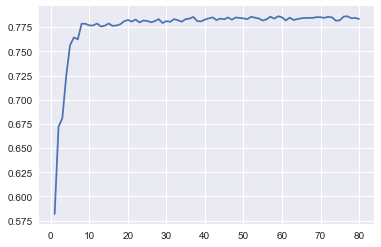

In [197]:
mm3 = automateDecisionTreeModelWithRFEForest()
plotAccuracyForModelFeatures(mm3)

In [198]:
print("The best accuracy for rfe (random forest) is: ", getMaximumAccuracyFeatures(mm3)[1], " with ", getMaximumAccuracyFeatures(mm3)[0], " features")

The best accuracy for rfe (random forest) is:  0.78625498008  with  59  features


In [199]:
best_feats = getMaximumAccuracyFeatures(mm3)[0]
mm3[best_feats]['cm'].print_stats()

population: 15060
P: 3700
N: 11360
PositiveTest: 4955
NegativeTest: 10105
TP: 2718
TN: 9123
FP: 2237
FN: 982
TPR: 0.734594594595
TNR: 0.803080985915
PPV: 0.548536831483
NPV: 0.902820385948
FPR: 0.196919014085
FDR: 0.451463168517
FNR: 0.265405405405
ACC: 0.78625498008
F1_score: 0.628076256499
MCC: 0.492629428576
informedness: 0.53767558051
markedness: 0.451357217431
prevalence: 0.245683930943
LRP: 3.73044014063
LRN: 0.330483986124
DOR: 11.2878090838
FOR: 0.0971796140524


## SUPPORT VECTOR MACHINES

In [204]:
def runSupportVectorMachineModel(train_x, train_y, test_x, test_y, kernel='rbf'):
    svm_model = svm.SVC()
    svm_model.fit(train_x, train_y)
    predicted = svm_model.predict(test_x)
    report = "-- CLASSIFICATION REPORT -- \n", metrics.classification_report(test_y, predicted), "-- CONFUSION MATRIX --  \n", confusion_matrix(Y_test, predicted), "\n", "-- ACCURACY SCORE -- \n ", metrics.accuracy_score(Y_test, predicted), "\n"
    accuracy_score = metrics.accuracy_score(Y_test, predicted)
    cm = ConfusionMatrix(Y_test, predicted)
    return cm, report,accuracy_score

def automateSVMModelWithChi2():
    models = {}
    for k,v in chi2_features.items():
        #print("******Chi2 Support Vector Machine model with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runSupportVectorMachineModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score, "to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
    return models

def automateSVMModelWithRFE():
    models = {}
    for k,v in rfe_svm_features.items():
        print("******RFE Support Vector Machine with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runSupportVectorMachineModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score,"to_plot":(k,score)}
        print("Accuracy: ", score*100, "%\n")
    return models

def automateSVMModelWithRFBKernel():
    models = {}
    #print("******RFB Kernel Support Vector Machine ****** \n")

    cm, report, score = runSupportVectorMachineModel(X, Y, X_test, Y_test)
    models = {"cm":cm, "report":report, "accuracy":score}
    #print("Accuracy: ", score*100, "%\n")
    return models

def automateSVMModelWithPolyKernel(train_x, train_y, test_x, test_y):
    models = {}
    #print("******Poly Kernel Support Vector Machine ****** \n")

    cm, report, score = runSupportVectorMachineModel(train_x, train_y, test_x, test_y, kernel='poly')
    models = {"cm":cm, "report":report, "accuracy":score}
    #print("Accuracy: ", score*100, "%\n")
    return models


def svmOnTrainSet(train_x, train_y):
    model = svm.SVC()
    model.fit(train_x, train_y)
    predicted = model.predict(train_x)
    report = "-- CLASSIFICATION REPORT -- \n", metrics.classification_report(train_y, predicted), "-- CONFUSION MATRIX --  \n", confusion_matrix(train_y, predicted), "\n", "-- ACCURACY SCORE -- \n ", metrics.accuracy_score(train_y, predicted), "\n"
    accuracy_score = metrics.accuracy_score(train_y, predicted)
    cm = ConfusionMatrix(train_y, predicted)
    return cm, report,accuracy_score

def svmOnTrainSetPoly(train_x, train_y):
    model = svm.SVC(kernel='poly')
    model.fit(train_x, train_y)
    predicted = model.predict(train_x)
    report = "-- CLASSIFICATION REPORT -- \n", metrics.classification_report(train_y, predicted), "-- CONFUSION MATRIX --  \n", confusion_matrix(train_y, predicted), "\n", "-- ACCURACY SCORE -- \n ", metrics.accuracy_score(train_y, predicted), "\n"
    accuracy_score = metrics.accuracy_score(train_y, predicted)
    cm = ConfusionMatrix(train_y, predicted)
    return cm, report,accuracy_score

def automateSVMModelWithRFEForest():
    models = {}
    for k,v in rfe_forest_features.items():
        print("******RFE Support Vector Machine with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runSupportVectorMachineModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score,"to_plot":(k,score)}
        print("Accuracy: ", score*100, "%\n")
    return models

#### RUN SVM DATASET WITH ALL FEATURES (80)

In [201]:
svm_cm, svm_report, svm_acc = runSupportVectorMachineModel(X,Y,X_test,Y_test)
print("(TEST SET) RBF kernel Accuracy when all features are used is: ", svm_acc*100, "%")
svm_cm.print_stats()

(TEST SET) RBF kernel Accuracy when all features are used is:  82.8552456839 %
population: 15060
P: 3700
N: 11360
PositiveTest: 4978
NegativeTest: 10082
TP: 3048
TN: 9430
FP: 1930
FN: 652
TPR: 0.823783783784
TNR: 0.830105633803
PPV: 0.612294094014
NPV: 0.935330291609
FPR: 0.169894366197
FDR: 0.387705905986
FNR: 0.176216216216
ACC: 0.828552456839
F1_score: 0.702466005992
MCC: 0.598402699335
informedness: 0.653889417587
markedness: 0.547624385622
prevalence: 0.245683930943
LRP: 4.84879988797
LRN: 0.212281677223
DOR: 22.8413490575
FOR: 0.0646697083912


In [202]:
svmt_cm, svmt_report, svmt_acc = svmOnTrainSet(X,Y)
print("(TRAINING SET) RBF kernel Accuracy when all features are used is: ", svmt_acc*100, "%")
svmt_cm.print_stats()

(TRAINING SET) RBF kernel Accuracy when all features are used is:  82.4194653873 %
population: 17508
P: 7508
N: 10000
PositiveTest: 7878
NegativeTest: 9630
TP: 6154
TN: 8276
FP: 1724
FN: 1354
TPR: 0.819659030368
TNR: 0.8276
PPV: 0.781162731658
NPV: 0.859397715472
FPR: 0.1724
FDR: 0.218837268342
FNR: 0.180340969632
ACC: 0.824194653873
F1_score: 0.79994800468
MCC: 0.643901028033
informedness: 0.647259030368
markedness: 0.64056044713
prevalence: 0.428832533699
LRP: 4.75440272835
LRN: 0.217908373166
DOR: 21.8183572263
FOR: 0.140602284528


In [205]:
svm_ply_cm, svm_ply_rep, svm_ply_acc = automateSVMModelWithPolyKernel(X,Y,X_test,Y_test)
print("(Test SET) POLY kernel Accuracy when all features are used is: ", svm_ply_acc*100, "%")


(Test SET) POLY kernel Accuracy when all features are used is:  accuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracy %


AttributeError: 'str' object has no attribute 'print_stats'

In [206]:
svm_ply_cm

'cm'

In [ ]:
svm_ply2_cm, svm_ply2_rep, svm_ply2_acc = svmOnTrainSetPoly(X,Y)
print("(Train SET) POLY kernel Accuracy when all features are used is: ", svm_ply2_acc*100, "%")
svm_ply2_cm.print_stats()

In [ ]:
sv_ch = automateSVMModelWithChi2()
plotAccuracyForModelFeatures(sv_ch)

In [ ]:
best_feats = getMaximumAccuracyFeatures(sv_ch)[0]
sv_ch[best_feats]['cm'].print_stats()